### Obogaćivanje prostornim podatcima

In [6]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString
import plotly.express as px
import folium
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import osmnx as ox
import time
import os
import warnings

warnings.filterwarnings('ignore')

### Učitavanje podataka

In [7]:
df = pd.read_csv('dataset/transformed_deliverytime.csv')
df.dropna(inplace=True)
df.head()

,Unnamed: 0,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weatherconditions,...,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),Datetime_Ordered,Datetime_Picked,distance(km)
0,0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,...,2,snack,motorcycle,0,0,Urban,24,2022-03-19 11:30:00,2022-03-19 11:45:00,3.020737
1,1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,...,2,snack,scooter,1,0,Metropolitian,33,2022-03-25 19:45:00,2022-03-25 19:50:00,20.143737
2,2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,...,0,drinks,motorcycle,1,0,Urban,26,2022-03-19 08:30:00,2022-03-19 08:45:00,1.549693
3,3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,...,0,buffet,motorcycle,1,0,Metropolitian,21,2022-04-05 18:00:00,2022-04-05 18:10:00,7.774497
4,4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,...,1,snack,scooter,1,0,Metropolitian,30,2022-03-26 13:30:00,2022-03-26 13:45:00,6.197898


### Pregled prosječne brzine dostave

<Axes: >

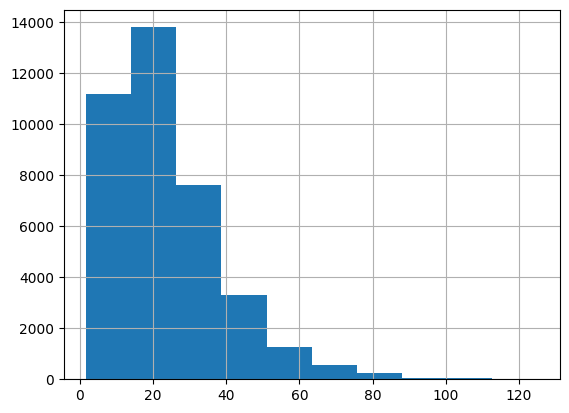

In [8]:
min_speed = df['distance(km)'] / df['Time_taken(min)'] * 60
min_speed.hist()

### Izdvajanje podataka o gradovima iz Delivery_person_ID
Delivery_person_ID ima format : <city_code>RES<restaurant_id>DEL<delivery_id>

In [9]:
df['city_code'] = df['Delivery_person_ID'].str.split("RES").str[0]
df.groupby(['city_code']).count()['ID']

city_code
AGR        513
ALH        511
AURG       502
BANG      2878
BHP        431
CHEN      2835
COIMB     2897
DEH        436
GOA        547
HYD       2905
INDO      2860
JAP       3137
KNP        616
KOC        635
KOL        647
LUDH       627
MUM       2880
MYS       2715
PUNE      2839
RANCHI    2313
SUR       2908
VAD       1432
Name: ID, dtype: int64

In [10]:
cities = df['city_code'].unique()
cities

array(['INDO', 'BANG', 'COIMB', 'CHEN', 'HYD', 'RANCHI', 'MYS', 'DEH',
       'KOC', 'PUNE', 'LUDH', 'KNP', 'MUM', 'KOL', 'JAP', 'SUR', 'GOA',
       'AGR', 'ALH', 'VAD', 'AURG', 'BHP'], dtype=object)

### Izračun graničnih okvira (bounding box) gradova 

In [11]:
city_bbox = {}
for city in cities:
    city_df = df[df['city_code'] == city]
    rest_lat_min = city_df['Restaurant_latitude'].min()
    rest_long_min = city_df['Restaurant_longitude'].min()
    rest_lat_max = city_df['Restaurant_latitude'].max()
    rest_long_max = city_df['Restaurant_longitude'].max()

    del_lat_min = city_df['Delivery_location_latitude'].min()
    del_long_min = city_df['Delivery_location_longitude'].min()
    del_lat_max = city_df['Delivery_location_latitude'].max()
    del_long_max = city_df['Delivery_location_longitude'].max()

    lat_min = rest_lat_min if rest_lat_min < del_lat_min else del_lat_min
    lat_max = rest_lat_max if rest_lat_max > del_lat_max else del_lat_max
    long_min = rest_long_min if rest_long_min < del_long_min else del_long_min
    long_max = rest_long_max if rest_long_max > del_long_max else del_long_max

    bbox = [(lat_min, long_min), (lat_max, long_max)]
    city_bbox[city] = bbox

In [12]:
map = folium.Map(location=[17, 80.110], tiles="CartoDB Positron", zoom_start=5)
for city in city_bbox:
    folium.Rectangle(city_bbox[city],
                    color="green",
                    weight=2,
                    fill=True,
                    fill_color="pink",
                    popup=city,
                    fill_opacity=0.5).add_to(map)
map

### Dohvat i spremanje grafova cestovnih mreža svakog grada
- koristi se za izračun statističkih podataka o cestovnoj mreži

In [13]:
for city in city_bbox:
    filepath = f"graphs/{city}-road_network_graph.graphml"
    if os.path.exists(filepath):
        print(f"Road network graph for {city} already exists.")
    else:
        try:
            print(f"Fetching graph for : {city}")
            bbox = city_bbox[city]
            start = time.time()
            graph = ox.graph_from_bbox(bbox[1][0], bbox[0][0], bbox[1][1], bbox[0][1], truncate_by_edge=True)
            print(f"Fetching runtime : {time.time() - start}")
            start = time.time()
            ox.save_graphml(graph, filepath=filepath)
            print(f"Saving runtime : {time.time() - start}")
        except:
            print(f"Unsuccessful fetching for {city}.")

Road network graph for INDO already exists.
Road network graph for BANG already exists.
Road network graph for COIMB already exists.
Road network graph for CHEN already exists.
Fetching graph for : HYD
Unsuccessful fetching for HYD.
Road network graph for RANCHI already exists.
Road network graph for MYS already exists.
Road network graph for DEH already exists.
Road network graph for KOC already exists.
Road network graph for PUNE already exists.
Road network graph for LUDH already exists.
Road network graph for KNP already exists.
Road network graph for MUM already exists.
Road network graph for KOL already exists.
Road network graph for JAP already exists.
Road network graph for SUR already exists.
Road network graph for GOA already exists.
Road network graph for AGR already exists.
Road network graph for ALH already exists.
Road network graph for VAD already exists.
Road network graph for AURG already exists.
Road network graph for BHP already exists.


### "Map matchanje" koordinatnih točaka restorana i lokacija dostave OSM(OpenStreetMap) čvorovima

In [14]:
df_with_spatial = pd.DataFrame()
for city in cities:
    filepath = f"graphs/{city}-road_network_graph.graphml"
    city_df = df[df["city_code"] == city]
    if os.path.exists(filepath):
        print(f"Working on spatial enrichment for {city}...")
        road_network_graph = ox.load_graphml(filepath=filepath)
        city_df['Restaurant_node_id'] = ox.nearest_nodes(
            road_network_graph, 
            city_df['Restaurant_longitude'], 
            city_df['Restaurant_latitude']    
        )
        city_df['Delivery_node_id'] = ox.nearest_nodes(
            road_network_graph, 
            city_df['Delivery_location_longitude'], 
            city_df['Delivery_location_latitude']    
        )
    else:
        print(f"Spatial enrichment for {city} not possible.")
    df_with_spatial = pd.concat([df_with_spatial, city_df])    

Working on spatial enrichment for INDO...
Working on spatial enrichment for BANG...
Working on spatial enrichment for COIMB...
Working on spatial enrichment for CHEN...
Spatial enrichment for HYD not possible.
Working on spatial enrichment for RANCHI...
Working on spatial enrichment for MYS...
Working on spatial enrichment for DEH...
Working on spatial enrichment for KOC...
Working on spatial enrichment for PUNE...
Working on spatial enrichment for LUDH...
Working on spatial enrichment for KNP...
Working on spatial enrichment for MUM...
Working on spatial enrichment for KOL...
Working on spatial enrichment for JAP...
Working on spatial enrichment for SUR...
Working on spatial enrichment for GOA...
Working on spatial enrichment for AGR...
Working on spatial enrichment for ALH...
Working on spatial enrichment for VAD...
Working on spatial enrichment for AURG...
Working on spatial enrichment for BHP...


In [15]:
df_with_spatial.dropna(inplace=True, how='any')
df_with_spatial

,Unnamed: 0,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weatherconditions,...,multiple_deliveries,Festival,City,Time_taken(min),Datetime_Ordered,Datetime_Picked,distance(km),city_code,Restaurant_node_id,Delivery_node_id
0,0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,...,0,0,Urban,24,2022-03-19 11:30:00,2022-03-19 11:45:00,3.020737,INDO,6.596573e+09,6.596218e+09
78,93,0x6d19,INDORES12DEL02,38,4.9,22.748060,75.893400,22.768060,75.913400,Cloudy,...,1,0,Urban,15,2022-03-11 08:40:00,2022-03-11 08:55:00,3.020707,INDO,2.022008e+09,8.434225e+09
88,104,0x6757,INDORES05DEL02,24,4.3,22.727021,75.884167,22.747021,75.904167,Sandstorms,...,0,0,Urban,19,2022-03-15 08:45:00,2022-03-15 09:00:00,3.020916,INDO,2.023845e+09,8.390302e+09
103,121,0x2bc0,INDORES14DEL01,39,4.2,22.761593,75.886362,22.871593,75.996362,Fog,...,0,0,Metropolitian,39,2022-03-29 18:45:00,2022-03-29 18:50:00,16.610673,INDO,2.020718e+09,5.206546e+09
114,133,0x977d,INDORES19DEL02,27,4.7,22.745536,75.893106,22.765536,75.913106,Cloudy,...,0,0,Metropolitian,14,2022-03-09 09:00:00,2022-03-09 09:05:00,3.020732,INDO,6.241359e+09,8.444592e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37658,45118,0xc560,BHPRES11DEL03,39,4.9,23.233219,77.433571,23.293219,77.493571,Sandstorms,...,0,0,Metropolitian,25,2022-02-15 18:15:00,2022-02-15 18:20:00,9.046874,BHP,1.111816e+10,4.182691e+09
37774,45251,0xc8aa,BHPRES16DEL03,33,4.6,23.264015,77.408236,23.324015,77.468236,Cloudy,...,1,0,Metropolitian,25,2022-02-15 17:45:00,2022-02-15 17:50:00,9.045935,BHP,8.956274e+09,8.837630e+09
37822,45306,0xe105,BHPRES17DEL02,28,4.7,23.218998,77.373573,23.348998,77.503573,Windy,...,0,0,Urban,24,2022-02-18 20:40:00,2022-02-18 20:50:00,19.600186,BHP,4.193415e+09,8.852759e+09
37919,45421,0xe0b2,BHPRES17DEL03,32,4.8,23.218998,77.373573,23.248998,77.403573,Fog,...,0,0,Metropolitian,23,2022-02-17 22:50:00,2022-02-17 23:00:00,4.523882,BHP,4.193415e+09,4.188757e+09


### Vizualizacija "map matchanih" čvorova

In [16]:
city_code = "INDO"
road_network_graph = ox.load_graphml(f'graphs/{city_code}-road_network_graph.graphml')
nodes, edges = ox.graph_to_gdfs(road_network_graph)

In [17]:
restaurant_node_ids = df_with_spatial[df_with_spatial['city_code'] == city_code]['Restaurant_node_id'].astype('int64').to_list()
nodes.loc[list(set(restaurant_node_ids))].explore()

In [18]:
delivery_node_ids = df_with_spatial[df_with_spatial['city_code'] == city_code]['Delivery_node_id'].astype('int64').to_list()
nodes.loc[list(set(delivery_node_ids))].explore()

### Određivanje najkraćeg puta od restorana do mjesta dostave

In [19]:
df_with_spatial['Restaurant_node_id'] = df_with_spatial['Restaurant_node_id'].astype('int64')
df_with_spatial['Delivery_node_id'] = df_with_spatial['Delivery_node_id'].astype('int64')

In [20]:
df_with_routes = pd.DataFrame()
for city_code in cities:
    filepath = f"graphs/{city_code}-road_network_graph.graphml"
    if os.path.exists(filepath):
        print(f"Beginning with {city_code}...")
        road_network_graph = ox.load_graphml(filepath=filepath)
        city_df = df_with_spatial[df_with_spatial['city_code'] == city_code]
        city_df['shortest_path'] = ox.shortest_path(road_network_graph, city_df['Restaurant_node_id'], city_df['Delivery_node_id'])
        df_with_routes = pd.concat([df_with_routes, city_df])
    else:
        print(f"Graph for {city_code} does'nt exists.")


Beginning with INDO...
Beginning with BANG...
Beginning with COIMB...
Beginning with CHEN...
Graph for HYD does'nt exists.
Beginning with RANCHI...
Beginning with MYS...
Beginning with DEH...
Beginning with KOC...
Beginning with PUNE...
Beginning with LUDH...
Beginning with KNP...
Beginning with MUM...
Beginning with KOL...
Beginning with JAP...
Beginning with SUR...
Beginning with GOA...
Beginning with AGR...
Beginning with ALH...
Beginning with VAD...
Beginning with AURG...
Beginning with BHP...


In [21]:
df_with_routes.to_csv('dataset/deliverytime_with_routes.csv')

### Izračun duljine najkraće rute

In [22]:
def shortest_path_length(edges, route_node_ids):
    if route_node_ids and len(route_node_ids) > 1:
        path_pairs = []
        for i in range(len(route_node_ids) - 1):
            path_pairs.append((route_node_ids[i], route_node_ids[i+1], 0))
        return edges.loc[path_pairs]['length'].sum()
    else:
        return -1

In [23]:
df_with_routes_length = pd.DataFrame()
for city_code in cities:
    filepath = f"graphs/{city_code}-road_network_graph.graphml"
    if os.path.exists(filepath):
        print(f"Beginning with {city_code}...")
        road_network_graph = ox.load_graphml(filepath=filepath)
        _, edges = ox.graph_to_gdfs(road_network_graph)
        city_df = df_with_routes[df_with_routes['city_code'] == city_code]
        city_df['shortest_path_length'] = city_df.apply(
            lambda x: shortest_path_length(edges, x['shortest_path']),
            axis=1
        )
        df_with_routes_length = pd.concat([df_with_routes_length, city_df])
    else:
        print(f"Graph for {city_code} does'nt exists.")


Beginning with INDO...
Beginning with BANG...
Beginning with COIMB...
Beginning with CHEN...
Graph for HYD does'nt exists.
Beginning with RANCHI...
Beginning with MYS...
Beginning with DEH...
Beginning with KOC...
Beginning with PUNE...
Beginning with LUDH...
Beginning with KNP...
Beginning with MUM...
Beginning with KOL...
Beginning with JAP...
Beginning with SUR...
Beginning with GOA...
Beginning with AGR...
Beginning with ALH...
Beginning with VAD...
Beginning with AURG...
Beginning with BHP...


In [24]:
df_with_routes_length.to_csv('dataset/deliverytime_with_route_lengths.csv')

In [25]:
df_with_routes_length

,Unnamed: 0,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weatherconditions,...,City,Time_taken(min),Datetime_Ordered,Datetime_Picked,distance(km),city_code,Restaurant_node_id,Delivery_node_id,shortest_path,shortest_path_length
0,0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,...,Urban,24,2022-03-19 11:30:00,2022-03-19 11:45:00,3.020737,INDO,6596573100,6596217680,"[6596573100, 6241358589, 8444869402, 624135858...",3940.990
78,93,0x6d19,INDORES12DEL02,38,4.9,22.748060,75.893400,22.768060,75.913400,Cloudy,...,Urban,15,2022-03-11 08:40:00,2022-03-11 08:55:00,3.020707,INDO,2022007672,8434225364,"[2022007672, 2022007827, 2022007883, 202200790...",4417.569
88,104,0x6757,INDORES05DEL02,24,4.3,22.727021,75.884167,22.747021,75.904167,Sandstorms,...,Urban,19,2022-03-15 08:45:00,2022-03-15 09:00:00,3.020916,INDO,2023845111,8390302151,"[2023845111, 2023845130, 2023845141, 844496039...",3743.853
103,121,0x2bc0,INDORES14DEL01,39,4.2,22.761593,75.886362,22.871593,75.996362,Fog,...,Metropolitian,39,2022-03-29 18:45:00,2022-03-29 18:50:00,16.610673,INDO,2020718366,5206545962,"[2020718366, 6590363360, 2021678355, 700731990...",21436.115
114,133,0x977d,INDORES19DEL02,27,4.7,22.745536,75.893106,22.765536,75.913106,Cloudy,...,Metropolitian,14,2022-03-09 09:00:00,2022-03-09 09:05:00,3.020732,INDO,6241358589,8444592232,"[6241358589, 8444869402, 6241358587, 624135858...",4107.151
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37658,45118,0xc560,BHPRES11DEL03,39,4.9,23.233219,77.433571,23.293219,77.493571,Sandstorms,...,Metropolitian,25,2022-02-15 18:15:00,2022-02-15 18:20:00,9.046874,BHP,11118161903,4182690937,"[11118161903, 3691350815, 3673163473, 36731634...",11909.411
37774,45251,0xc8aa,BHPRES16DEL03,33,4.6,23.264015,77.408236,23.324015,77.468236,Cloudy,...,Metropolitian,25,2022-02-15 17:45:00,2022-02-15 17:50:00,9.045935,BHP,8956273683,8837630348,"[8956273683, 3692791615, 9868387637, 419692916...",10125.584
37822,45306,0xe105,BHPRES17DEL02,28,4.7,23.218998,77.373573,23.348998,77.503573,Windy,...,Urban,24,2022-02-18 20:40:00,2022-02-18 20:50:00,19.600186,BHP,4193414860,8852758540,"[4193414860, 315580679, 315580681, 315580683, ...",22873.863
37919,45421,0xe0b2,BHPRES17DEL03,32,4.8,23.218998,77.373573,23.248998,77.403573,Fog,...,Metropolitian,23,2022-02-17 22:50:00,2022-02-17 23:00:00,4.523882,BHP,4193414860,4188756822,"[4193414860, 315580679, 315580681, 315580683, ...",5905.717


### Dohvat statistike gradova

In [26]:
def bbox_area(bbox: list[tuple])-> float:
    min_lat = bbox[0][0]
    min_long = bbox[0][1]
    max_lat = bbox[1][0]
    max_long = bbox[1][1]

    horiz_dist = geodesic((min_lat, min_long), (max_lat, min_long)).meters
    vertic_dist = geodesic((min_lat, min_long), (min_lat, max_long)).meters

    return horiz_dist * vertic_dist

In [27]:
city_basic_stats = []
for city_code in cities:
    filepath = f'graphs/{city_code}-road_network_graph.graphml'
    if os.path.exists(filepath):
        print(f'Starting with {city_code}...')
        graph = ox.load_graphml(filepath=filepath)
        bbox = city_bbox[city_code]
        area = bbox_area(bbox)
        basic_stats = ox.basic_stats(graph, area)
        basic_stats['city_code'] = city_code
        city_basic_stats.append(basic_stats)
    else:
        print(f"Graph doesn't exist for {city_code}")

Starting with INDO...
Starting with BANG...
Starting with COIMB...
Starting with CHEN...
Graph doesn't exist for HYD
Starting with RANCHI...
Starting with MYS...
Starting with DEH...
Starting with KOC...
Starting with PUNE...
Starting with LUDH...
Starting with KNP...
Starting with MUM...
Starting with KOL...
Starting with JAP...
Starting with SUR...
Starting with GOA...
Starting with AGR...
Starting with ALH...
Starting with VAD...
Starting with AURG...
Starting with BHP...


In [28]:
city_basic_stats[0]

{'n': 29465,
 'm': 77283,
 'k_avg': 5.245749193958934,
 'edge_length_total': 6472429.17899996,
 'edge_length_avg': 83.74971441325984,
 'streets_per_node_avg': 2.7533684031902257,
 'streets_per_node_counts': {0: 0,
  1: 5430,
  2: 32,
  3: 20423,
  4: 3536,
  5: 43,
  6: 1},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.18428644154081114,
  2: 0.001086034277956898,
  3: 0.693127439334804,
  4: 0.12000678771423723,
  5: 0.0014593585610045818,
  6: 3.393857118615306e-05},
 'intersection_count': 24035,
 'street_length_total': 3428185.4680000152,
 'street_segment_count': 40455,
 'street_length_avg': 84.7407111111115,
 'circuity_avg': 1.0550864061573038,
 'self_loop_proportion': 0.000939315288592263,
 'node_density_km': 64.53748829753354,
 'intersection_density_km': 52.64410423319935,
 'edge_density_km': 14176.627266123354,
 'street_density_km': 7508.7893949711715,
 'city_code': 'INDO'}

In [29]:
import json

with open('dataset/city_basic_stats.json', 'w') as file:
    file.write(json.dumps(city_basic_stats, indent=4))